In [2]:
# Provides ways to work with large multidimensional arrays
import numpy as np 
# Allows for further data manipulation and analysis
import pandas as pd
from pandas_datareader import data # Reads stock data 
import matplotlib.pyplot as plt # Plotting
import matplotlib.dates as mdates # Styling dates
%matplotlib inline

import datetime as dt # For defining dates
# import mplfinance as mpf # Matplotlib finance

import time

# Used to get data from a directory
import os
from os import listdir
from os.path import isfile, join

#Statsmodels is a great library we can use to run regressions.
import statsmodels.api as sm
# Seaborn extends the capabilities of Matplotlib
import seaborn as sns
# Used for calculating regressions
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [3]:
#change the tickers here according to what's in the portfolio
tickers = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

start_date = '2017-01-01'
end_date = '2021-12-31'

panel_data = data.DataReader(tickers,'yahoo', start_date, end_date)

In [4]:
#check that all stocks have the same amount of data otherwise change the date range

adj_close = panel_data['Adj Close']
adj_close.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2017-01-03 to 2021-12-31
Data columns (total 32 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MGIC    1259 non-null   float64
 1   NSIT    1259 non-null   float64
 2   ON      1259 non-null   float64
 3   TTD     1259 non-null   float64
 4   IDXX    1259 non-null   float64
 5   BDSI    1259 non-null   float64
 6   CDMO    1259 non-null   float64
 7   ICLR    1259 non-null   float64
 8   MEDP    1259 non-null   float64
 9   OPRX    1259 non-null   float64
 10  RGEN    1259 non-null   float64
 11  TNDM    1259 non-null   float64
 12  XOMA    1259 non-null   float64
 13  CBRE    1259 non-null   float64
 14  SBAC    1259 non-null   float64
 15  ODFL    1259 non-null   float64
 16  GLDD    1259 non-null   float64
 17  HSON    1259 non-null   float64
 18  KRNT    1259 non-null   float64
 19  QRHC    1259 non-null   float64
 20  RCII    1259 non-null   float64
 21  SAIA    1259 non-nu

## Function that saves dataframe to CSV

In [5]:
def save_dataframe_to_csv(kind, df, ticker):
    df.to_csv(kind + ticker + '.csv')

In [6]:
for ticker in tickers:
    panel_data = data.DataReader(ticker,'yahoo', start_date, end_date)
#     close = panel_data['Close']
    adj_close = panel_data['Adj Close']
    save_dataframe_to_csv('adj_close', adj_close, ticker)

## Function that returns dataframe from a CSV

In [7]:
def get_df_from_csv(kind, ticker):
    try:
        df = pd.read_csv(kind + ticker + '.csv', index_col='Date', 
                         parse_dates=True)
    except FileNotFoundError:
        pass
        # print("File Doesn't Exist")
    else:
        return df

## Add Daily Return to dataframe

In [8]:
def add_daily_return_to_df(kind, df, ticker):
    df['daily_return'] = (df['Adj Close'] / df['Adj Close'].shift(1)) - 1
    # Save data to a CSV file
    save_dataframe_to_csv(kind, df, ticker)
    return df

In [9]:
for ticker in tickers:
    df = get_df_from_csv('adj_close', ticker)
    add_daily_return_to_df('adj_close', df, ticker)

## Merge multiple stocks in one dataframe by col name

In [10]:
def merge_df_by_column_name(col_name, sdate, edate, *tickers):
    # Will hold data for all dataframes with the same column name
    mult_df = pd.DataFrame()
    
    for x in tickers:
        df = get_df_from_csv('adj_close', x)
        
        # NEW Check if your dataframe has duplicate indexes
        if not df.index.is_unique:
            # Delete duplicates 
            df = df.loc[~df.index.duplicated(), :]
        
        mask = (df.index >= sdate) & (df.index <= edate)
        mult_df[x] = df.loc[mask][col_name]
        
    return mult_df

## Get stock prices on date

In [11]:
def get_prices_on_date(stocks_df, date):
    return stocks_df.loc[pd.DatetimeIndex([date])]['Adj Close'].item()

## Returns the value of portfolio by date

In [12]:
def get_port_val_by_date(date, shares, tickers):
    port_prices = merge_df_by_column_name('Adj Close',  date, date, *port_list)
    # Convert from dataframe to Python list
    port_prices = port_prices.values.tolist()
    # Trick that converts a list of lists into a single list
    port_prices = sum(port_prices, [])
    
    # Create a list of values by multiplying shares by price
    value_list = []
    for price, share in zip(port_prices, shares):
        value_list.append(price * share)
    
    return sum(value_list)

## Find Daily Return for Whole Portfolio

In [13]:
def get_port_daily_return(sdate, edate, shares, tickers):
    # Merge all daily prices for all stocks into 1 dataframe
    mult_df = merge_df_by_column_name('Adj Close',  sdate, 
                                  edate, *port_list)
    
    # Get the number of stocks in portfolio
    num_cols = len(mult_df.columns)
    
    # Multiply each stock column by the number of shares
    i = 0
    while i < num_cols:
        mult_df[tickers[i]] = mult_df[tickers[i]].apply(lambda x: x * shares[i])
        i += 1
        
    # Create a new column with the sums of all stocks named Total
    mult_df['Total'] = mult_df.iloc[:, 0:num_cols].sum(axis=1)
    
    # Add column for portfolio daily return
    mult_df['daily_return'] = (mult_df['Total'] / mult_df['Total'].shift(1)) - 1
    
    return mult_df

In [14]:
#change to the list of stocks we using
port_list = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

#add in the weightage of stocks
port_shares = [0.049444,0.040776,0.005548,0.114230,0.033946,0.005736,0.013283,0.012181,0.004217,0.030748,
              0.032924,0.000344,0.006622,0.045058,0.094942,0.054688,0.000469,0.005589,0.005780,0.004535,0.002252,
              0.000152,0.002185,0.029349,0.001412,0.032881,0.008251,0.022279,0.004344,0.008703,0.027128,0.300000]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.290281,1.658768,0.070404,0.307621,3.992050,0.010038,0.021041,0.910042,0.151432,0.074718,...,0.077382,1.426970,0.399294,0.122916,0.175845,0.233676,1.813507,0.5832,28.257208,NaN
2017-01-04,0.292385,1.688126,0.072124,0.309563,3.936039,0.010038,0.021742,0.935744,0.153457,0.073795,...,0.079854,1.492732,0.399965,0.126180,0.176757,0.242814,1.882955,0.5841,28.512413,0.009031
2017-01-05,0.294488,1.657952,0.071292,0.313561,3.936378,0.010612,0.021041,0.928314,0.151095,0.074718,...,0.078918,1.491153,0.399697,0.125092,0.177887,0.243249,1.864508,0.5589,28.273255,-0.008388
2017-01-06,0.292385,1.634710,0.072179,0.316417,4.017849,0.010898,0.021041,0.958036,0.151053,0.074718,...,0.079124,1.506016,0.394058,0.129443,0.172544,0.240638,1.852028,0.5766,28.275140,0.000067
2017-01-09,0.292385,1.630224,0.074010,0.324870,4.040253,0.010612,0.021041,0.978987,0.150631,0.072873,...,0.078422,1.520944,0.388553,0.130531,0.168634,0.239333,1.849858,0.5643,28.223072,-0.001841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.728889,3.039851,0.177481,10.643609,16.875915,0.024665,0.151293,2.344964,0.586753,0.971022,...,0.150929,21.759660,1.701981,0.341852,0.690044,0.927653,9.533322,0.1092,118.693692,0.007034
2020-12-28,0.723164,3.083073,0.177259,9.511018,16.793087,0.023862,0.150629,2.331200,0.582832,0.990393,...,0.151621,21.822791,1.706998,0.342960,0.719193,0.930003,9.531694,0.1092,117.316563,-0.011602
2020-12-29,0.743199,3.042705,0.175650,9.370173,16.771700,0.023460,0.147707,2.357024,0.581398,0.955340,...,0.152425,21.898417,1.612156,0.330774,0.737568,0.917731,9.582152,0.1134,117.096718,-0.001874


## Get old data for portfolio

In [15]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-01-01', 
                                    port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.290281,1.658768,0.070404,0.307621,3.992050,0.010038,0.021041,0.910042,0.151432,0.074718,...,0.077382,1.426970,0.399294,0.122916,0.175845,0.233676,1.813507,0.5832,28.257208,NaN
2017-01-04,0.292385,1.688126,0.072124,0.309563,3.936039,0.010038,0.021742,0.935744,0.153457,0.073795,...,0.079854,1.492732,0.399965,0.126180,0.176757,0.242814,1.882955,0.5841,28.512413,0.009031
2017-01-05,0.294488,1.657952,0.071292,0.313561,3.936378,0.010612,0.021041,0.928314,0.151095,0.074718,...,0.078918,1.491153,0.399697,0.125092,0.177887,0.243249,1.864508,0.5589,28.273255,-0.008388
2017-01-06,0.292385,1.634710,0.072179,0.316417,4.017849,0.010898,0.021041,0.958036,0.151053,0.074718,...,0.079124,1.506016,0.394058,0.129443,0.172544,0.240638,1.852028,0.5766,28.275140,0.000067
2017-01-09,0.292385,1.630224,0.074010,0.324870,4.040253,0.010612,0.021041,0.978987,0.150631,0.072873,...,0.078422,1.520944,0.388553,0.130531,0.168634,0.239333,1.849858,0.5643,28.223072,-0.001841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,0.728889,3.039851,0.177481,10.643609,16.875915,0.024665,0.151293,2.344964,0.586753,0.971022,...,0.150929,21.759660,1.701981,0.341852,0.690044,0.927653,9.533322,0.1092,118.693692,0.007034
2020-12-28,0.723164,3.083073,0.177259,9.511018,16.793087,0.023862,0.150629,2.331200,0.582832,0.990393,...,0.151621,21.822791,1.706998,0.342960,0.719193,0.930003,9.531694,0.1092,117.316563,-0.011602
2020-12-29,0.743199,3.042705,0.175650,9.370173,16.771700,0.023460,0.147707,2.357024,0.581398,0.955340,...,0.152425,21.898417,1.612156,0.330774,0.737568,0.917731,9.582152,0.1134,117.096718,-0.001874


## Forecasting

In [16]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2020-12-22', '2020-12-23', '2020-12-24', '2020-12-25',
               '2020-12-26', '2020-12-27', '2020-12-28', '2020-12-29',
               '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='Date', length=1459, freq='D')

In [17]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [18]:
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.290281,1.658768,0.070404,0.307621,3.992050,0.010038,0.021041,0.910042,0.151432,0.074718,...,0.077382,1.426970,0.399294,0.122916,0.175845,0.233676,1.813507,0.5832,28.257208,NaN
2017-01-04,0.292385,1.688126,0.072124,0.309563,3.936039,0.010038,0.021742,0.935744,0.153457,0.073795,...,0.079854,1.492732,0.399965,0.126180,0.176757,0.242814,1.882955,0.5841,28.512413,0.009031
2017-01-05,0.294488,1.657952,0.071292,0.313561,3.936378,0.010612,0.021041,0.928314,0.151095,0.074718,...,0.078918,1.491153,0.399697,0.125092,0.177887,0.243249,1.864508,0.5589,28.273255,-0.008388
2017-01-06,0.292385,1.634710,0.072179,0.316417,4.017849,0.010898,0.021041,0.958036,0.151053,0.074718,...,0.079124,1.506016,0.394058,0.129443,0.172544,0.240638,1.852028,0.5766,28.275140,0.000067
2017-01-07,0.292385,1.634710,0.072179,0.316417,4.017849,0.010898,0.021041,0.958036,0.151053,0.074718,...,0.079124,1.506016,0.394058,0.129443,0.172544,0.240638,1.852028,0.5766,28.275140,0.000067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,0.728889,3.039851,0.177481,10.643609,16.875915,0.024665,0.151293,2.344964,0.586753,0.971022,...,0.150929,21.759660,1.701981,0.341852,0.690044,0.927653,9.533322,0.1092,118.693692,0.007034
2020-12-28,0.723164,3.083073,0.177259,9.511018,16.793087,0.023862,0.150629,2.331200,0.582832,0.990393,...,0.151621,21.822791,1.706998,0.342960,0.719193,0.930003,9.531694,0.1092,117.316563,-0.011602
2020-12-29,0.743199,3.042705,0.175650,9.370173,16.771700,0.023460,0.147707,2.357024,0.581398,0.955340,...,0.152425,21.898417,1.612156,0.330774,0.737568,0.917731,9.582152,0.1134,117.096718,-0.001874


In [19]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [20]:
tot_port_df

,Total
Date,
2017-01-03,28.257208
2017-01-04,28.512413
2017-01-05,28.273255
2017-01-06,28.275140
2017-01-07,28.275140
...,...
2020-12-27,118.693692
2020-12-28,117.316563
2020-12-29,117.096718


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1 2]
Observations : 1459


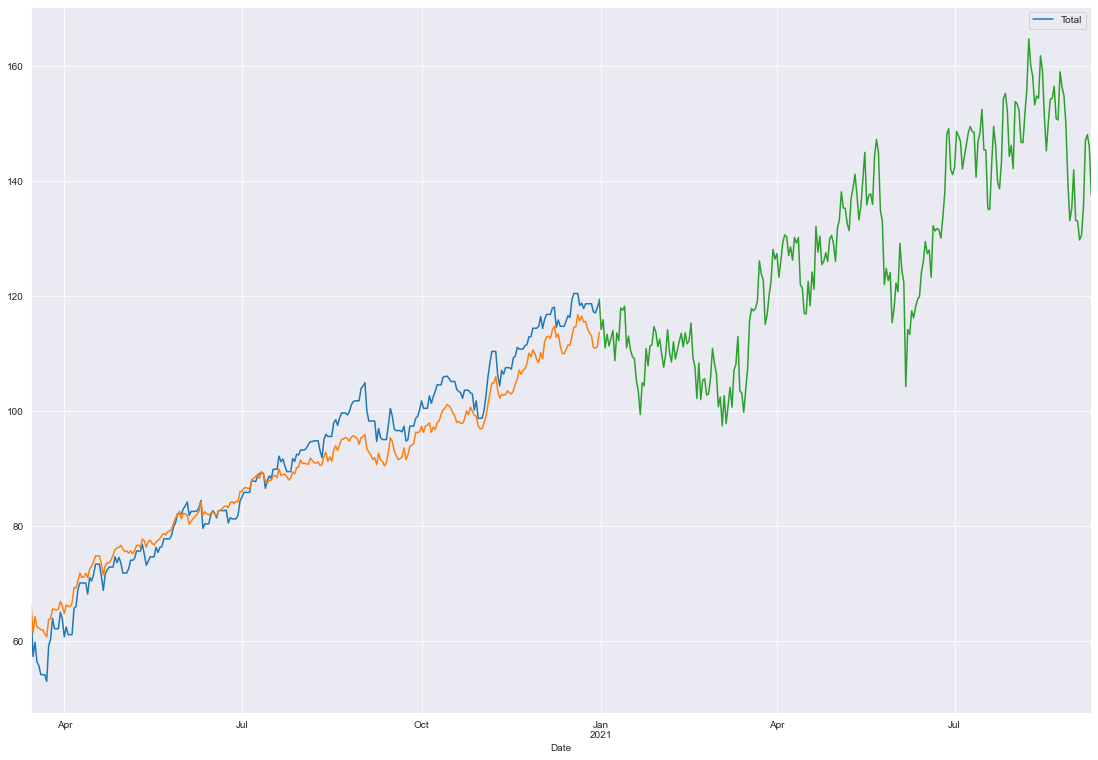

In [21]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1167] # First 80% 
test_df = tot_port_df.iloc[1167:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

## Calculate annualized returns for forecasted

In [22]:
forecast

2020-12-31    119.483237
2021-01-01    114.230879
2021-01-02    115.915663
2021-01-03    111.028472
2021-01-04    113.397306
                 ...    
2021-09-05    135.563910
2021-09-06    147.071956
2021-09-07    148.107860
2021-09-08    145.956506
2021-09-09    137.602272
Freq: D, Length: 253, dtype: float64

In [23]:
forecast_df = pd.DataFrame(forecast)

In [24]:
forecast_df

,0
2020-12-31,119.483237
2021-01-01,114.230879
2021-01-02,115.915663
2021-01-03,111.028472
2021-01-04,113.397306
...,...
2021-09-05,135.563910
2021-09-06,147.071956
2021-09-07,148.107860
2021-09-08,145.956506


In [25]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [26]:
return_series

,0
2020-12-31,NaN
2021-01-01,-0.043959
2021-01-02,-0.029858
2021-01-03,-0.070761
2021-01-04,-0.050935
...,...
2021-09-05,0.134585
2021-09-06,0.230900
2021-09-07,0.239570
2021-09-08,0.221565


In [27]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2021-09-09  15.164499


## Backtesting

In [28]:
tickers2 = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

#change the date according to the year you want to backtest and compare with forecasted
start_date = '2020-12-31'
end_date = '2021-12-30'

panel_data2 = data.DataReader(tickers2,'yahoo', start_date, end_date)

In [29]:
panel_data2 = panel_data2['Adj Close']

In [30]:
panel_data2

Symbols,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,SBLK,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,15.175845,75.440002,32.480000,81.800003,496.959991,4.27,11.640000,193.660004,137.860001,31.200001,...,6.983870,33.610001,110.180000,694.780029,197.821671,15.095527,172.740005,107.250000,350.779999,0.370
2020-12-31,15.098663,76.089996,32.730000,80.099998,499.869995,4.20,11.540000,194.979996,139.199997,31.160000,...,7.178995,34.680000,111.260002,705.669983,194.192825,15.314301,174.979996,105.709999,348.029999,0.361
2021-01-04,14.432972,75.279999,32.669998,77.343002,491.769989,4.29,11.860000,192.020004,134.419998,33.360001,...,7.203386,34.169998,107.459999,729.770020,187.812454,15.065693,167.089996,103.410004,356.399994,0.354
2021-01-05,14.375086,76.860001,33.220001,78.853996,497.260010,4.44,12.920000,195.690002,133.990005,34.590000,...,7.618027,34.900002,107.949997,735.109985,195.837769,15.403802,172.490005,108.160004,366.500000,0.377
2021-01-06,14.124245,79.989998,34.060001,74.060997,483.600006,4.50,13.280000,205.479996,139.880005,35.410000,...,7.561116,34.889999,110.769997,755.979980,204.889938,16.457901,182.380005,113.449997,363.250000,0.432
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,20.666519,103.220001,66.760002,96.050003,645.020020,3.22,29.540001,307.929993,223.369995,60.490002,...,19.650398,92.900002,154.710007,1067.000000,236.369995,26.640947,193.559998,163.690002,391.559998,1.243
2021-12-27,21.160698,104.000000,69.779999,97.680000,654.840027,3.15,30.270000,307.619995,227.899994,63.349998,...,19.771755,96.000000,155.289993,1093.939941,237.190002,27.130413,196.960007,165.490005,400.750000,1.252
2021-12-28,20.824657,104.279999,68.320000,94.790001,651.280029,3.11,29.280001,306.049988,218.300003,60.730000,...,19.613060,93.010002,155.020004,1088.469971,238.820007,27.180359,196.470001,164.350006,400.070007,1.245


## Portfolio Analysis

In [31]:
return_series2 = panel_data2.pct_change().dropna()
return_series2.head()

Symbols,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,SBLK,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,-0.005086,0.008616,0.007697,-0.020782,0.005856,-0.016393,-0.008591,0.006816,0.009720,-0.001282,...,0.027939,0.031836,0.009802,0.015674,-0.018344,0.014493,0.012967,-0.014359,-0.007840,-0.024324
2021-01-04,-0.044089,-0.010645,-0.001833,-0.034419,-0.016204,0.021429,0.027730,-0.015181,-0.034339,0.070603,...,0.003398,-0.014706,-0.034154,0.034152,-0.032856,-0.016234,-0.045091,-0.021758,0.024050,-0.019391
2021-01-05,-0.004011,0.020988,0.016835,0.019536,0.011164,0.034965,0.089376,0.019113,-0.003199,0.036870,...,0.057562,0.021364,0.004560,0.007317,0.042730,0.022442,0.032318,0.045934,0.028339,0.064972
2021-01-06,-0.017450,0.040723,0.025286,-0.060783,-0.027471,0.013514,0.027864,0.050028,0.043958,0.023706,...,-0.007471,-0.000287,0.026123,0.028390,0.046223,0.068431,0.057337,0.048909,-0.008868,0.145889
2021-01-07,0.019126,0.016377,0.038168,0.030272,0.023966,0.082222,-0.003012,0.019321,0.000143,0.059023,...,0.054839,0.001433,0.022750,0.079447,0.023015,0.004834,0.010582,0.041869,0.011122,0.050926


In [32]:
portfolio_weights = [0.049444,0.040776,0.005548,0.114230,0.033946,0.005736,0.013283,0.012181,0.004217,0.030748,
              0.032924,0.000344,0.006622,0.045058,0.094942,0.054688,0.000469,0.005589,0.005780,0.004535,0.002252,
              0.000152,0.002185,0.029349,0.001412,0.032881,0.008251,0.022279,0.004344,0.008703,0.027128,0.300000]

#apply the weights to returns
wt_portfolio = return_series2 * portfolio_weights
wt_portfolio.head()

Symbols,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,SBLK,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-31,-0.000251,0.000351,0.000043,-0.002374,0.000199,-0.000094,-0.000114,0.000083,4.098915e-05,-0.000039,...,0.000061,0.000934,0.000014,0.000515,-0.000151,0.000323,0.000056,-0.000125,-0.000213,-0.007297
2021-01-04,-0.002180,-0.000434,-0.000010,-0.003932,-0.000550,0.000123,0.000368,-0.000185,-1.448079e-04,0.002171,...,0.000007,-0.000432,-0.000048,0.001123,-0.000271,-0.000362,-0.000196,-0.000189,0.000652,-0.005817
2021-01-05,-0.000198,0.000856,0.000093,0.002232,0.000379,0.000201,0.001187,0.000233,-1.348965e-05,0.001134,...,0.000126,0.000627,0.000006,0.000241,0.000353,0.000500,0.000140,0.000400,0.000769,0.019492
2021-01-06,-0.000863,0.001661,0.000140,-0.006943,-0.000933,0.000078,0.000370,0.000609,1.853730e-04,0.000729,...,-0.000016,-0.000008,0.000037,0.000934,0.000381,0.001525,0.000249,0.000426,-0.000241,0.043767
2021-01-07,0.000946,0.000668,0.000212,0.003458,0.000814,0.000472,-0.000040,0.000235,6.026142e-07,0.001815,...,0.000120,0.000042,0.000032,0.002612,0.000190,0.000108,0.000046,0.000364,0.000302,0.015278


In [33]:
portfolio_returns1 = wt_portfolio.sum(axis = 1)
portfolio_returns1.head()

Date
2020-12-31   -0.004679
2021-01-04   -0.017285
2021-01-05    0.029139
2021-01-06    0.041150
2021-01-07    0.032807
dtype: float64

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/pos.py:26: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  warnings.warn(


Start date,2020-12-31
End date,2021-12-30
Total months,12
,Backtest
Annual return,114.5%
Cumulative returns,114.5%
Annual volatility,27.3%
Sharpe ratio,2.94
Calmar ratio,11.83
Stability,0.93
Max drawdown,-9.7%


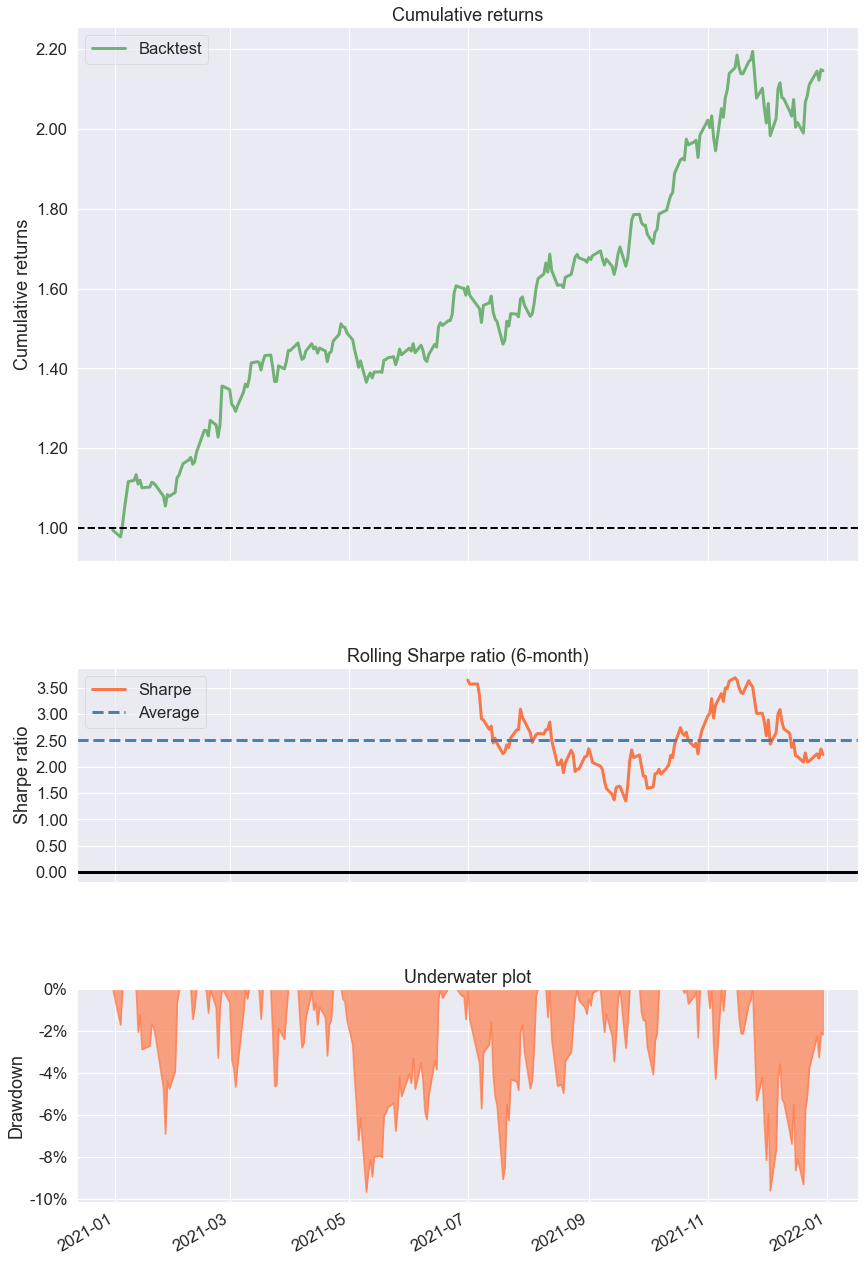

In [34]:
import pyfolio as pf
pf.create_simple_tear_sheet(portfolio_returns1)

## Extra stuff

In [35]:
import itertools

In [36]:
weights = [0.049444,0.040776,0.005548,0.114230,0.033946,0.005736,0.013283,0.012181,0.004217,0.030748,
              0.032924,0.000344,0.006622,0.045058,0.094942,0.054688,0.000469,0.005589,0.005780,0.004535,0.002252,
              0.000152,0.002185,0.029349,0.001412,0.032881,0.008251,0.022279,0.004344,0.008703,0.027128,0.300000]

In [37]:
panel_data2 = panel_data2 * weights

In [38]:
num_cols = len(panel_data2.columns)
    
# Create a new column with the sums of all stocks named Total
panel_data2['Total'] = panel_data2.iloc[:, 0:num_cols].sum(axis=1)

In [39]:
#forecasted portfolio value
panel_data2

Symbols,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,TRNS,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total
Date,,,,,,,,,,,,,,,,,,,,,
2020-12-30,0.750354,3.076142,0.180199,9.344014,16.869804,0.024493,0.154614,2.358973,0.581356,0.959338,...,0.986420,0.155574,22.845062,1.632227,0.336313,0.750383,0.933397,9.515960,0.1110,118.015543
2020-12-31,0.746538,3.102646,0.181586,9.149823,16.968587,0.024091,0.153286,2.375051,0.587006,0.958108,...,1.017823,0.157099,23.203135,1.602285,0.341187,0.760113,0.919994,9.441358,0.1083,119.131687
2021-01-04,0.713624,3.069617,0.181253,8.834891,16.693624,0.024607,0.157536,2.338996,0.566849,1.025753,...,1.002855,0.151734,23.995568,1.549641,0.335649,0.725839,0.899977,9.668419,0.1062,118.271157
2021-01-05,0.710762,3.134043,0.184305,9.007492,16.879988,0.025468,0.171616,2.383700,0.565036,1.063573,...,1.024280,0.152425,24.171151,1.615857,0.343181,0.749297,0.941317,9.942412,0.1131,119.334557
2021-01-06,0.698359,3.261672,0.188965,8.459988,16.416286,0.025812,0.176398,2.502952,0.589874,1.088787,...,1.023987,0.156407,24.857378,1.690547,0.366666,0.792259,0.987355,9.854246,0.1296,118.895266
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-23,1.021835,4.208899,0.370384,10.971792,21.895850,0.018470,0.392380,3.750895,0.941951,1.859947,...,2.726522,0.218451,35.084027,1.950289,0.593534,0.840825,1.424594,10.622240,0.3729,168.662596
2021-12-27,1.046270,4.240704,0.387139,11.157986,22.229200,0.018068,0.402076,3.747119,0.961054,1.947886,...,2.817504,0.219269,35.969839,1.957055,0.604438,0.855594,1.440260,10.871546,0.3756,172.152415
2021-12-28,1.029654,4.252121,0.379039,10.827862,22.108352,0.017839,0.388926,3.727995,0.920571,1.867326,...,2.729751,0.218888,35.789981,1.970504,0.605551,0.853466,1.430338,10.853099,0.3735,170.962559


In [40]:
actual_portfolio_value = []

for value in panel_data2['Total']:
    actual_portfolio_value.append(value)

In [41]:
actual_portfolio_value

[118.01554285677338,
 119.1316866366534,
 118.27115688480569,
 119.33455650735094,
 118.89526633742929,
 122.74998069269778,
 126.53824831147934,
 122.77467106777331,
 124.19923348987984,
 124.10665026289628,
 123.89819825678467,
 123.81982525848767,
 124.60504760549284,
 126.37479388728761,
 125.99329317360115,
 125.94035063642835,
 126.88680555307006,
 125.46744178561687,
 121.95189183783098,
 122.51805330781221,
 119.97159001214074,
 124.25603287254333,
 127.8834672188263,
 125.13073511764836,
 126.70153356124091,
 127.61990587513591,
 127.52788814343164,
 127.72599361910272,
 126.30679650951527,
 127.23029844237136,
 128.23371479900908,
 126.6935070421946,
 126.21014103322243,
 126.59760999049163,
 127.17234856972478,
 123.19434386237121,
 120.55536778995514,
 122.83695800466631,
 119.48448787415818,
 119.94709604050854,
 122.91773634859109,
 120.67988020126248,
 115.56376428328944,
 111.13889282472798,
 112.42215309219722,
 110.68988289140775,
 116.84425734736159,
 117.41521858411

In [42]:
forecasted_portfolio_value = []

for value in forecast_df[0]:
    forecasted_portfolio_value.append(value)

In [43]:
forecasted_portfolio_value

[119.48323739558542,
 114.23087864284555,
 115.91566283927321,
 111.02847229441356,
 113.3973062803904,
 111.34823063075147,
 112.70798524522853,
 114.0335232365215,
 108.79712177428222,
 113.61165186116355,
 112.26470077614455,
 117.95412728606419,
 117.57370841654829,
 118.27557401656223,
 111.03396502169964,
 113.08842635844917,
 110.64340155913187,
 109.50846967550623,
 109.14808294633809,
 105.39614464032397,
 103.46697981813567,
 99.43065371879838,
 104.94478325513626,
 104.42621718551337,
 110.91381736150804,
 107.9084346865014,
 111.35273875535205,
 111.54136555118248,
 114.71085496038737,
 113.75614601645412,
 111.25011862890629,
 112.54785343881083,
 109.86972056600281,
 107.65802904434362,
 109.82622626699917,
 114.18465203346938,
 110.1434321620895,
 108.55569767419303,
 112.07411275382002,
 109.07964757330268,
 110.61228950914715,
 112.19118342036043,
 113.57279561290414,
 111.18126721069206,
 113.63562401288583,
 111.72832780680693,
 112.21446153335184,
 115.327174576511,

## Calculate MAPE of forecasted period

In [44]:
# Define the dataset as python lists
# actual = [136, 120, 138, 155, 149]
# forecast = [134, 124, 132, 141, 149]

# Consider a list APE to store the
# APE value for each of the records in dataset
APE = []

# Iterate over the list values
for day in range(253):

	# Calculate percentage error
	per_err = (actual_portfolio_value[day] - forecasted_portfolio_value[day]) / actual_portfolio_value[day]

	# Take absolute value of
	# the percentage error (APE)
	per_err = abs(per_err)

	# Append it to the APE list
	APE.append(per_err)

# Calculate the MAPE
MAPE = sum(APE)/len(APE)

# Print the MAPE value and percentage
print(f'''
MAPE : { round(MAPE, 2) }
MAPE % : { round(MAPE*100, 2) } %
''')


MAPE : 0.09
MAPE % : 9.13 %



## Mean Squared Error

In [45]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(actual_portfolio_value, forecasted_portfolio_value))

247.21275607324253


## Forecast for future

In [46]:
#change to the list of stocks we using
port_list = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX"]

#add in the weightage of stocks
port_shares = [0.049444,0.040776,0.005548,0.114230,0.033946,0.005736,0.013283,0.012181,0.004217,0.030748,
              0.032924,0.000344,0.006622,0.045058,0.094942,0.054688,0.000469,0.005589,0.005780,0.004535,0.002252,
              0.000152,0.002185,0.029349,0.001412,0.032881,0.008251,0.022279,0.004344,0.008703,0.027128,0.300000]

# tot_port_df = get_port_daily_return('2020-01-02', '2020-12-31', 
#                                     port_shares, port_list)

#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.290281,1.658768,0.070404,0.307621,3.992050,0.010038,0.021041,0.910042,0.151432,0.074718,...,0.077382,1.426970,0.399294,0.122916,0.175845,0.233676,1.813507,0.5832,28.257208,NaN
2017-01-04,0.292385,1.688126,0.072124,0.309563,3.936039,0.010038,0.021742,0.935744,0.153457,0.073795,...,0.079854,1.492732,0.399965,0.126180,0.176757,0.242814,1.882955,0.5841,28.512413,0.009031
2017-01-05,0.294488,1.657952,0.071292,0.313561,3.936378,0.010612,0.021041,0.928314,0.151095,0.074718,...,0.078918,1.491153,0.399697,0.125092,0.177887,0.243249,1.864508,0.5589,28.273255,-0.008388
2017-01-06,0.292385,1.634710,0.072179,0.316417,4.017849,0.010898,0.021041,0.958036,0.151053,0.074718,...,0.079124,1.506016,0.394058,0.129443,0.172544,0.240638,1.852028,0.5766,28.275140,0.000067
2017-01-09,0.292385,1.630224,0.074010,0.324870,4.040253,0.010612,0.021041,0.978987,0.150631,0.072873,...,0.078422,1.520944,0.388553,0.130531,0.168634,0.239333,1.849858,0.5643,28.223072,-0.001841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.046270,4.240704,0.387139,11.157986,22.229200,0.018068,0.402076,3.747119,0.961054,1.947886,...,0.219269,35.969839,1.957055,0.604438,0.855594,1.440260,10.871546,0.3756,172.152415,0.020691
2021-12-28,1.029654,4.252121,0.379039,10.827862,22.108352,0.017839,0.388926,3.727995,0.920571,1.867326,...,0.218888,35.789981,1.970504,0.605551,0.853466,1.430338,10.853099,0.3735,170.962559,-0.006912
2021-12-29,1.031609,4.324702,0.382424,10.574271,22.258053,0.017782,0.402608,3.751626,0.929722,1.829199,...,0.219382,35.715011,1.976444,0.604661,0.895646,1.437388,10.878328,0.3882,171.412511,0.002632


In [47]:
#change the dates according to what you put on top
tot_port_df = get_port_daily_return('2017-01-01', '2021-12-31', 
                                    port_shares, port_list)
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.290281,1.658768,0.070404,0.307621,3.992050,0.010038,0.021041,0.910042,0.151432,0.074718,...,0.077382,1.426970,0.399294,0.122916,0.175845,0.233676,1.813507,0.5832,28.257208,NaN
2017-01-04,0.292385,1.688126,0.072124,0.309563,3.936039,0.010038,0.021742,0.935744,0.153457,0.073795,...,0.079854,1.492732,0.399965,0.126180,0.176757,0.242814,1.882955,0.5841,28.512413,0.009031
2017-01-05,0.294488,1.657952,0.071292,0.313561,3.936378,0.010612,0.021041,0.928314,0.151095,0.074718,...,0.078918,1.491153,0.399697,0.125092,0.177887,0.243249,1.864508,0.5589,28.273255,-0.008388
2017-01-06,0.292385,1.634710,0.072179,0.316417,4.017849,0.010898,0.021041,0.958036,0.151053,0.074718,...,0.079124,1.506016,0.394058,0.129443,0.172544,0.240638,1.852028,0.5766,28.275140,0.000067
2017-01-09,0.292385,1.630224,0.074010,0.324870,4.040253,0.010612,0.021041,0.978987,0.150631,0.072873,...,0.078422,1.520944,0.388553,0.130531,0.168634,0.239333,1.849858,0.5643,28.223072,-0.001841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.046270,4.240704,0.387139,11.157986,22.229200,0.018068,0.402076,3.747119,0.961054,1.947886,...,0.219269,35.969839,1.957055,0.604438,0.855594,1.440260,10.871546,0.3756,172.152415,0.020691
2021-12-28,1.029654,4.252121,0.379039,10.827862,22.108352,0.017839,0.388926,3.727995,0.920571,1.867326,...,0.218888,35.789981,1.970504,0.605551,0.853466,1.430338,10.853099,0.3735,170.962559,-0.006912
2021-12-29,1.031609,4.324702,0.382424,10.574271,22.258053,0.017782,0.402608,3.751626,0.929722,1.829199,...,0.219382,35.715011,1.976444,0.604661,0.895646,1.437388,10.878328,0.3882,171.412511,0.002632


In [48]:
tot_port_df = tot_port_df.asfreq('d')
tot_port_df.index

DatetimeIndex(['2017-01-03', '2017-01-04', '2017-01-05', '2017-01-06',
               '2017-01-07', '2017-01-08', '2017-01-09', '2017-01-10',
               '2017-01-11', '2017-01-12',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='Date', length=1824, freq='D')

In [49]:
# Delete NaNs for nontrading days
tot_port_df = tot_port_df.fillna(method='ffill')

In [50]:
tot_port_df

,MGIC,NSIT,ON,TTD,IDXX,BDSI,CDMO,ICLR,MEDP,OPRX,...,HLT,TSLA,CHDN,CLAR,FIVE,FOXF,LULU,^FVX,Total,daily_return
Date,,,,,,,,,,,,,,,,,,,,,
2017-01-03,0.290281,1.658768,0.070404,0.307621,3.992050,0.010038,0.021041,0.910042,0.151432,0.074718,...,0.077382,1.426970,0.399294,0.122916,0.175845,0.233676,1.813507,0.5832,28.257208,NaN
2017-01-04,0.292385,1.688126,0.072124,0.309563,3.936039,0.010038,0.021742,0.935744,0.153457,0.073795,...,0.079854,1.492732,0.399965,0.126180,0.176757,0.242814,1.882955,0.5841,28.512413,0.009031
2017-01-05,0.294488,1.657952,0.071292,0.313561,3.936378,0.010612,0.021041,0.928314,0.151095,0.074718,...,0.078918,1.491153,0.399697,0.125092,0.177887,0.243249,1.864508,0.5589,28.273255,-0.008388
2017-01-06,0.292385,1.634710,0.072179,0.316417,4.017849,0.010898,0.021041,0.958036,0.151053,0.074718,...,0.079124,1.506016,0.394058,0.129443,0.172544,0.240638,1.852028,0.5766,28.275140,0.000067
2017-01-07,0.292385,1.634710,0.072179,0.316417,4.017849,0.010898,0.021041,0.958036,0.151053,0.074718,...,0.079124,1.506016,0.394058,0.129443,0.172544,0.240638,1.852028,0.5766,28.275140,0.000067
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.046270,4.240704,0.387139,11.157986,22.229200,0.018068,0.402076,3.747119,0.961054,1.947886,...,0.219269,35.969839,1.957055,0.604438,0.855594,1.440260,10.871546,0.3756,172.152415,0.020691
2021-12-28,1.029654,4.252121,0.379039,10.827862,22.108352,0.017839,0.388926,3.727995,0.920571,1.867326,...,0.218888,35.789981,1.970504,0.605551,0.853466,1.430338,10.853099,0.3735,170.962559,-0.006912
2021-12-29,1.031609,4.324702,0.382424,10.574271,22.258053,0.017782,0.402608,3.751626,0.929722,1.829199,...,0.219382,35.715011,1.976444,0.604661,0.895646,1.437388,10.878328,0.3882,171.412511,0.002632


In [51]:
# Delete all unneeded columns - basically delete all except Total
del_col = ["MGIC", "NSIT", "ON", "TTD", "IDXX", "BDSI", "CDMO", "ICLR", "MEDP", "OPRX", "RGEN", "TNDM", "XOMA",
          "CBRE", "SBAC", "ODFL", "GLDD", "HSON", "KRNT", "QRHC", "RCII", "SAIA", "SBLK", "TRNS", "HLT", "TSLA",
          "CHDN", "CLAR", "FIVE", "FOXF", "LULU", "^FVX", "daily_return"]

for x in del_col:
    tot_port_df = tot_port_df.drop([x], axis=1)

In [52]:
tot_port_df

,Total
Date,
2017-01-03,28.257208
2017-01-04,28.512413
2017-01-05,28.273255
2017-01-06,28.275140
2017-01-07,28.275140
...,...
2021-12-27,172.152415
2021-12-28,170.962559
2021-12-29,171.412511


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use t

Lags : [1]
Observations : 1824


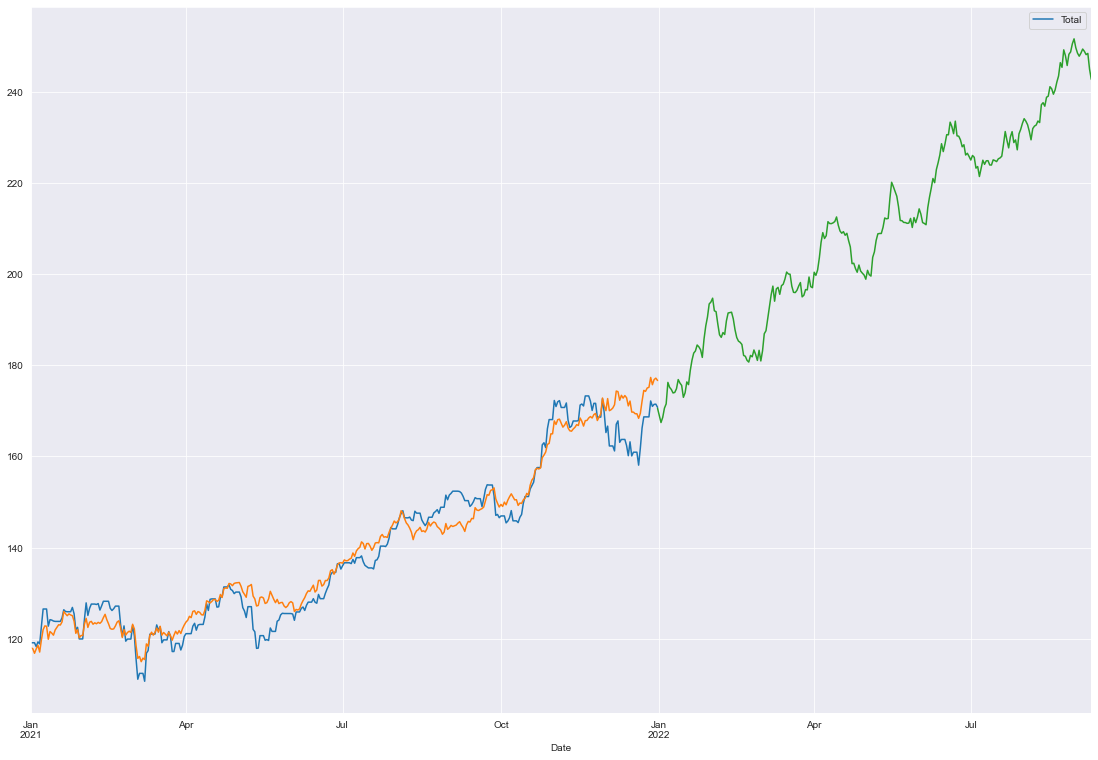

In [53]:
# Set style for seaborn plot
sns.set_style('darkgrid')
# Add automatic datetime converters
pd.plotting.register_matplotlib_converters()
# Default figure size
sns.mpl.rc('figure',figsize=(19, 13))

# Set fig and ax
fig, ax = plt.subplots()

# Figure out optimum lags for this data set
lags = ar_select_order(tot_port_df, maxlag=30)
print("Lags :", lags.ar_lags)

# Create our model using whole data set
model = AutoReg(tot_port_df['Total'], lags.ar_lags)
model_fit = model.fit()

# Define training and testing area
print("Observations :", len(tot_port_df)) # 1095 observations

train_df = tot_port_df.iloc[0:1459] # First 80% 
test_df = tot_port_df.iloc[1459:] # Last 20%

# Define training model for 459 days (Play with Number & Test)
# and White's covariance estimator
train_model = AutoReg(tot_port_df['Total'], 459).fit(cov_type="HC0")

# # Define start and end for prediction 
start = len(train_df)
end = len(train_df) + len(test_df) - 1

prediction = train_model.predict(start=start, end=end, dynamic=True)

# Plot testing data with prediction
ax = test_df.plot(ax=ax) # blue
ax = prediction.plot(ax=ax) # orange

# Predict 60 days into the future
forecast = train_model.predict(start=end, end=end+252, dynamic=True)
ax = forecast.plot(ax=ax) # Green

In [54]:
## Calculate annualized returns for forecasted

In [55]:
forecast

2021-12-31    170.535756
2022-01-01    168.935083
2022-01-02    167.423481
2022-01-03    168.550249
2022-01-04    170.577274
                 ...    
2022-09-05    248.814717
2022-09-06    248.094163
2022-09-07    248.363226
2022-09-08    244.894018
2022-09-09    242.672133
Freq: D, Length: 253, dtype: float64

In [56]:
forecast_df = pd.DataFrame(forecast)

In [57]:
forecast_df

,0
2021-12-31,170.535756
2022-01-01,168.935083
2022-01-02,167.423481
2022-01-03,168.550249
2022-01-04,170.577274
...,...
2022-09-05,248.814717
2022-09-06,248.094163
2022-09-07,248.363226
2022-09-08,244.894018


In [58]:
return_series = (1 + forecast_df.pct_change()).cumprod() - 1

In [59]:
return_series

,0
2021-12-31,NaN
2022-01-01,-0.009386
2022-01-02,-0.018250
2022-01-03,-0.011643
2022-01-04,0.000243
...,...
2022-09-05,0.459018
2022-09-06,0.454793
2022-09-07,0.456370
2022-09-08,0.436027


In [60]:
#calculate annualized return
total_return = return_series.tail(1)

annualized_return = ((1 + total_return)**(1))-1

print(annualized_return*100)

                    0
2022-09-09  42.299855
